<a href="https://colab.research.google.com/github/yebiFesseha/hello-world/blob/master/%5BNew_Webinar%5D_Day_in_the_Life_of_a_Data_Scientist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A Day (Week) in the Life of a Data Scientist**


In [ ]:
x = 4
print(x)

4


## **Monday**
Today in our [sprint planning](https://www.atlassian.com/agile/scrum/sprint-planning) we were asked a question from one of our main stakeholders:

**BIG Question:** What is the risk factor in insuring a person?

> This is a big question and doesn't have a simple answer.  It will be better if we break this BIG question into smaller, more managable questions that we can answer with data.

After sprint planning, we sat down with stakeholders to gather requirements and further refine the question.  Below are questions we asked stakeholders along with their answers.

**Clarifying Questions to Refine Question:**
- How do we define risk factor?
  - We don't have a single metric that indicates risk, but we do have data about the amount of time a person takes off from work that we can use as a proxy.
  - We will bucket the absenteeism as our risk factor.
- Do we want to include very high risk people?
  - That remains to be seen.

#### Importing our Data
**The data we have is demographic, work, and behavioral information about employees from a courier company.**

> Pandas can work with information from all kinds of data sources. Below, we'll import the data we need from a GitHub URL and read it into a Pandas Dataframe using the Pandas [`read_csv`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function.

In [ ]:
# data analysis packages
import pandas as pd 
import numpy as np

# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# import the data from github
aaw = pd.read_csv('https://raw.githubusercontent.com/ephs08kmp/day_in_the_life/master/Absenteeism_at_work.csv', 
                  sep=';', index_col='ID')

### Initial EDA
EDA stands for Exploratory Data Analysis.
- During this phase of our project, we are trying to get acquainted with our data.
- We need to understand what structure it's currently in along with any patterns or insights that might help us answer questions and build more effective predictive models.

In [ ]:
# Check out the first lines of the data set
aaw.head()

,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
ID,,,,,,,,,,,,,,,,,,,,
11,26,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,4
36,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,0
3,23,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31,2
7,7,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24,4
11,23,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,2


In [ ]:
# Checking the size of our data (rows, columns)
aaw.shape

(740, 20)

In [ ]:
# Understand the basic statistical details of the data set
aaw.describe()

,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
count,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
mean,19.216216,6.324324,3.914865,2.544595,221.329730,29.631081,12.554054,36.450000,271.490235,94.587838,0.054054,1.291892,1.018919,0.567568,0.072973,0.745946,79.035135,172.114865,26.677027,6.924324
std,8.433406,3.436287,1.421675,1.111831,66.952223,14.836788,4.384873,6.478772,39.058116,3.779313,0.226277,0.673238,1.098489,0.495749,0.260268,1.318258,12.883211,6.034995,4.285452,13.330998
min,0.000000,0.000000,2.000000,1.000000,118.000000,5.000000,1.000000,27.000000,205.917000,81.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,56.000000,163.000000,19.000000,0.000000
25%,13.000000,3.000000,3.000000,2.000000,179.000000,16.000000,9.000000,31.000000,244.387000,93.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,69.000000,169.000000,24.000000,2.000000
50%,23.000000,6.000000,4.000000,3.000000,225.000000,26.000000,13.000000,37.000000,264.249000,95.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,83.000000,170.000000,25.000000,3.000000
75%,26.000000,9.000000,5.000000,4.000000,260.000000,50.000000,16.000000,40.000000,294.217000,97.000000,0.000000,1.000000,2.000000,1.000000,0.000000,1.000000,89.000000,172.000000,31.000000,8.000000
max,28.000000,12.000000,6.000000,4.000000,388.000000,52.000000,29.000000,58.000000,378.884000,100.000000,1.000000,4.000000,4.000000,1.000000,1.000000,8.000000,108.000000,196.000000,38.000000,120.000000


In [ ]:
# find percent missing values
aaw.isna().mean()

Reason for absence                 0.0
Month of absence                   0.0
Day of the week                    0.0
Seasons                            0.0
Transportation expense             0.0
Distance from Residence to Work    0.0
Service time                       0.0
Age                                0.0
Work load Average/day              0.0
Hit target                         0.0
Disciplinary failure               0.0
Education                          0.0
Son                                0.0
Social drinker                     0.0
Social smoker                      0.0
Pet                                0.0
Weight                             0.0
Height                             0.0
Body mass index                    0.0
Absenteeism time in hours          0.0
dtype: float64

Based on the above, we don't have any missing values to fill in.  Let's do some deeper EDA to better understand the data and see what kinds of patterns we can find in the data.

### Deeper EDA
During this part of EDA, we'll start to use visualizations to help answer questions for ourselves and for others.

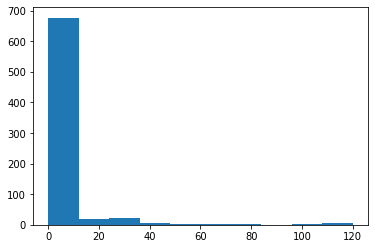

In [ ]:
# How is the absenteeism time distributed amongst the employees?
plt.hist(aaw['Absenteeism time in hours']);

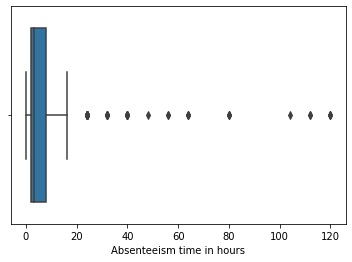

In [ ]:
# Boxplot of the same data to show outliers
sns.boxplot(data=aaw, x='Absenteeism time in hours');

Most people have very few hours of absenteeism from work.  A small number have a large number of hours off of work.

Based on this and the decision to bucket the risk groups, let's create 3 groups, `low` (0-8 hours off), `medium` (8-32 hours off), and `high` (32-120 hours off).

In [ ]:
# Create buckets using the pd.cut function
bins = [0,8,32,120]
labels = ['low',  'medium', 'high']
aaw['risk_bucket'] = pd.cut(aaw['Absenteeism time in hours'], bins=bins, labels=labels, include_lowest=True)

In [ ]:
# Count the number of employees that falls in each bucket
aaw['risk_bucket'].value_counts()

low       677
medium     41
high       22
Name: risk_bucket, dtype: int64

> *You be the Data Scientist*: The bins that we created are one of the many subjective choices that a data scientist makes in their daily workflow. Would you use the same bin sizes? The same number of bins? Why or why not?

We definitely have an unbalanced data set.  The large majority of employees are `low` risk.  We'll need to keep this in mind when modeling, as we'll be creating models that are really good at predicting `low` risk employees, but we also want to accurately predict `medium` and `high` risk employees.

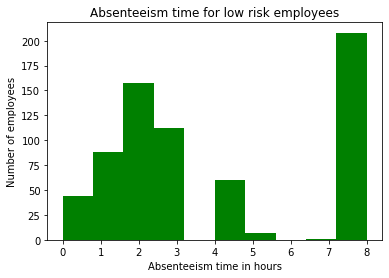

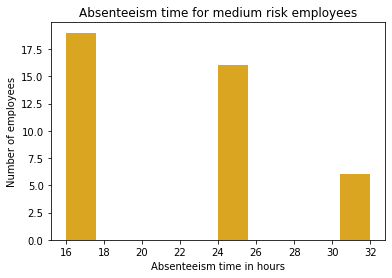

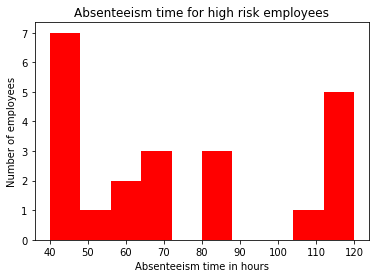

In [ ]:
# Create a function that will display distributions by risk level
def hist_by_risk(risk_level: str, color: str):
  plt.hist(aaw[aaw['risk_bucket']==risk_level]['Absenteeism time in hours'], color=color)
  plt.title(f'Absenteeism time for {risk_level} risk employees')
  plt.xlabel('Absenteeism time in hours')
  plt.ylabel('Number of employees')
  plt.show()

# Setting a color pallete for our risk buckets for consistency
risk_colors = {'low': 'green', 'medium': 'goldenrod', 'high': 'red'}

for risk, color in risk_colors.items():
  hist_by_risk(risk, color)

It seems that there is a fairly even distribution of absenteeism time across the buckets.

Now, let's take a look at how these buckets are distributed along with other variables.

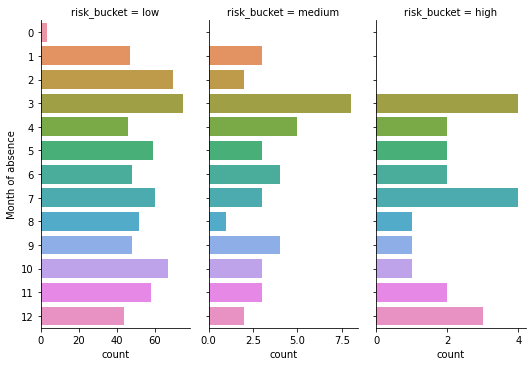

In [ ]:
# How does the month of absence impacted by the risk level?
sns.catplot(data=aaw, col='risk_bucket', y='Month of absence', kind='count', sharex=False, height=5, aspect=0.5, orient='v');


March is the most popular month for absenteeism across risk buckets, but July and December are the highest for the `high` risk bucket.
> Why do you think that may be? We don't have to know for sure, but it's important to try and add context to patterns you find.
- Add your thoughts here: ___

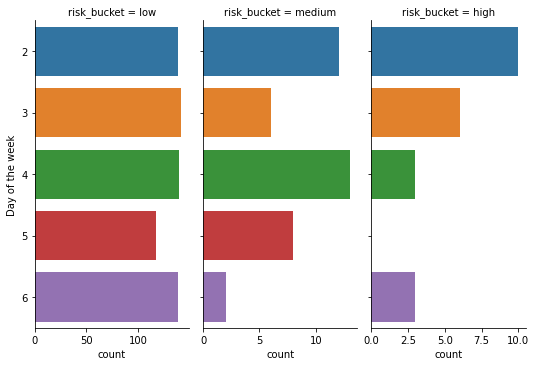

In [ ]:
# How does the day of the absence impacted by the risk level?
sns.catplot(data=aaw, col='risk_bucket', y='Day of the week', kind='count', sharex=False, height=5, aspect=0.5, orient='v');


`High` risk employees are more likely to take Mondays off, `medium` risk employees are most likely to take Wednesdays off, whereas `low` risk employees are equally as likely to take off any day.

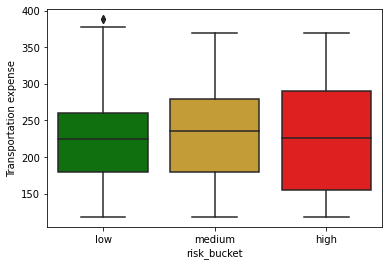

In [ ]:
# Does transportation expense impact the employee's risk of absenteeism?
sns.boxplot(data=aaw, x='risk_bucket', y='Transportation expense', palette=risk_colors);

`Low` risk employees have the same median transportation cost as `high` risk bucket employees, so transportation costs are not stong indicators of risk.

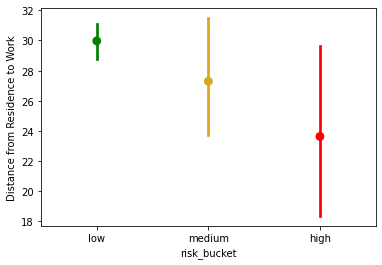

In [ ]:
# How does the distance the employee as to commute impact an employee's risk of absenteeism?
sns.pointplot(data=aaw, x='risk_bucket', y='Distance from Residence to Work', palette=risk_colors);

`High` risk employees actually live closer to work on average, and `low` risk employees live farther from work.

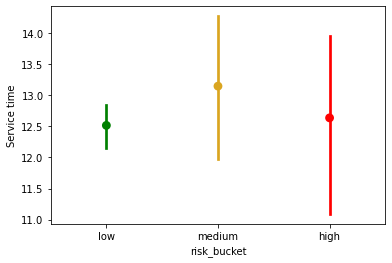

In [ ]:
# Do more experienced employees take more time off of work?
sns.pointplot(data=aaw, x='risk_bucket', y='Service time', palette=risk_colors);

There's a large overlap of error bars between the three groups, so employee experience doesn't impact risk groups.

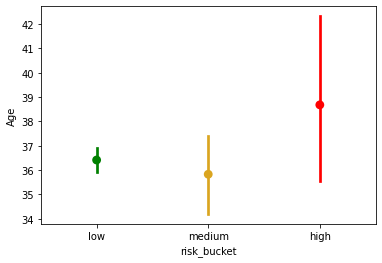

In [ ]:
# Does age impact the amount of time off taken?
sns.pointplot(data=aaw, x='risk_bucket', y='Age', palette=risk_colors);

`Medium` risk bucket employees have lowest mean age, but again, the error bars are large enough that there isn't a significant difference between the three buckets.

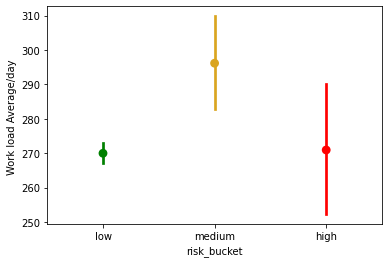

In [ ]:
# Does the expected work load (number of packages delivered) impact the amount of time an employee takes off?
sns.pointplot(data=aaw, x='risk_bucket', y='Work load Average/day ', palette=risk_colors);

The mean work load not different between `low` and `high` risk buckets, but the `medium` risk bucket has a significantly higher average work load per day than the `low` risk bucket employees. 

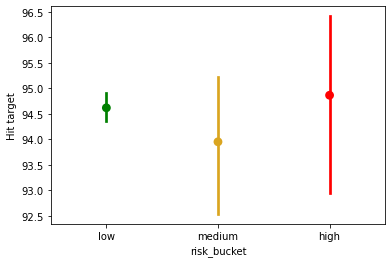

In [ ]:
# Do the risk buckets have different percent of time that they hit their targets?
sns.pointplot(data=aaw, x='risk_bucket', y='Hit target', palette=risk_colors);

Again, there is a large overlap in the percent of time employees hit their targets across the three groups.

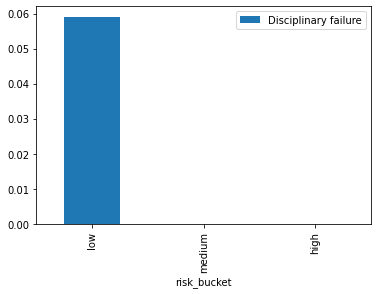

In [ ]:
# Are employees with disciplinary failures at a higher risk of absenteeism?
aaw.groupby('risk_bucket').agg({'Disciplinary failure': 'mean'}).plot(kind='bar');

The `low` risk bucket is the only bucket that has employees with disciplinary failures.  The proportion of these is so low that with the small number of employees in the `medium` and `high` risk buckets there are no employees with disciplinary failures in these buckets. 

> **This isn't a good indicator of risk.**

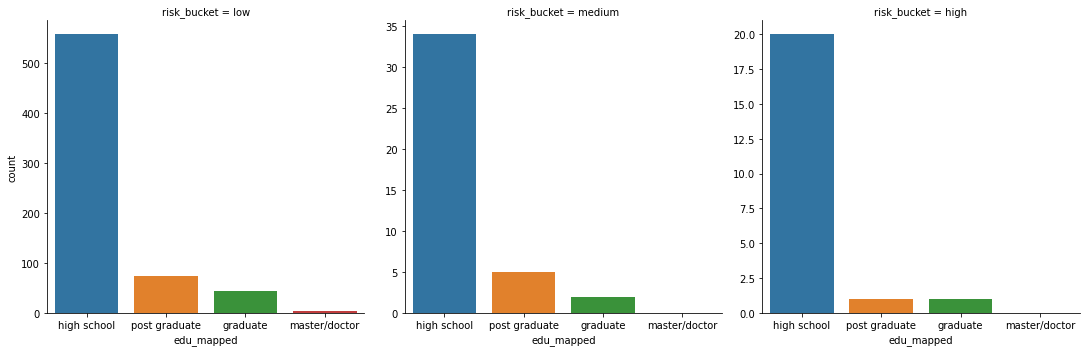

In [ ]:
# How do the level of education amongst the employees impact their risk level?

# Mapping the values of education back to their meaning
edu_map = {1:'high school', 2:'graduate', 3:'post graduate', 4:'master/doctor'}
aaw['edu_mapped'] = aaw['Education'].map(edu_map)
sns.catplot(data=aaw, col='risk_bucket', x='edu_mapped', kind='count', sharex=False, sharey=False);

All of the risk buckets have a majority of employees with a high school level education.  The `low` risk group has a slightly higher proprtion of college graduates, whereas the `high` risk group has the lowest proportion of employees that completed any post-graduate studies.

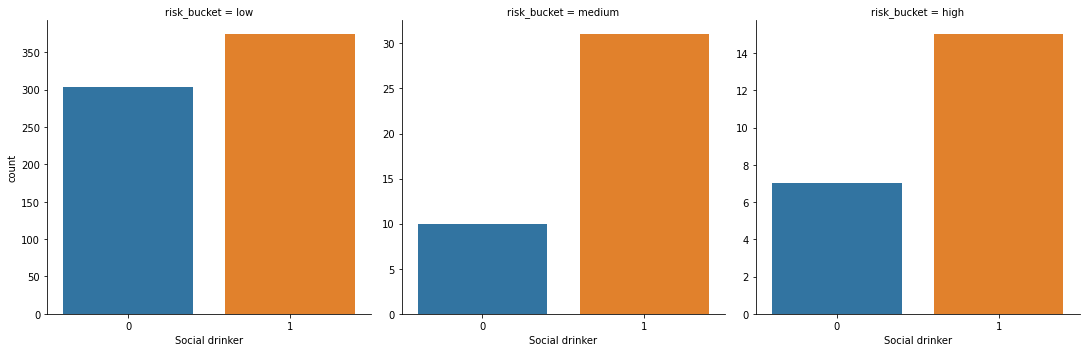

In [ ]:
# Does the riskiness of absenteeism relate to the proportion of social drinkers?
sns.catplot(data=aaw, col='risk_bucket', x='Social drinker', kind='count', sharex=False, sharey=False);

The `low` risk group has the highest proprotion of employees that abstain from drinking, but the `medium` and `high` groups have approximately the same proportion of social drinkers.

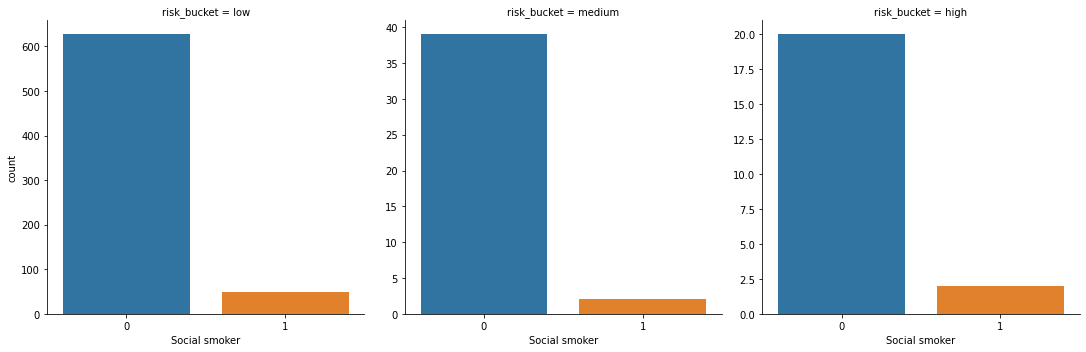

In [ ]:
# Does the riskiness of absenteeism relate to the proportion of social smokers?
sns.catplot(data=aaw, col='risk_bucket', x='Social smoker', kind='count', sharex=False, sharey=False);

All risk groups have approximately the same proportion of social smokers, and the majority of employees are non-smokers.

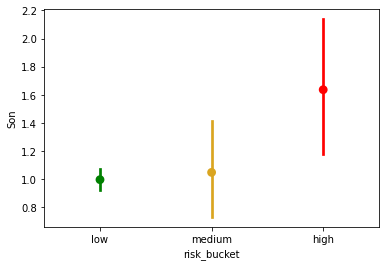

In [ ]:
# Do the number of children that an employee has impact their risk bucket?
sns.pointplot(data=aaw, x='risk_bucket', y='Son', palette=risk_colors);

The `low` and `medium` risk employees have approximately 1 child, whereas the `high` risk employees have an average of 1.7 children.  There is slight overlap in error bars between the `medium` and `high` risk buckets, so this is not as significant of a difference.

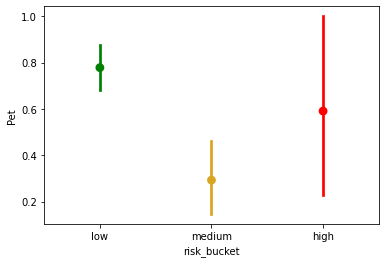

In [ ]:
# Does the number of pets a person have relate to their riskiness?
sns.pointplot(data=aaw, x='risk_bucket', y='Pet', palette=risk_colors);

The `low` risk bucket group has a higher average number of pets, but the large error bars means this is not significant in determining riskiness.

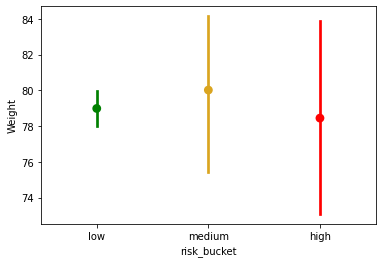

In [ ]:
# Does the weight of the employee impact their risk for taking time off work?
sns.pointplot(data=aaw, x='risk_bucket', y='Weight', palette=risk_colors);

There is a large overlap of weights amongst the three groups.

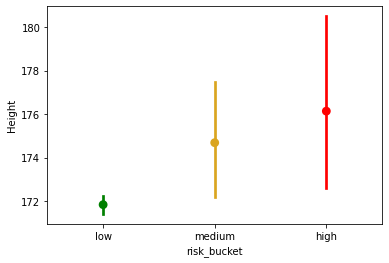

In [ ]:
# Does the height of the employee impact their risk for taking time off work?
sns.pointplot(data=aaw, x='risk_bucket', y='Height', palette=risk_colors);

The `low` risk employees are shorter than the `medium` and `high` risk employees.  This suggests that shorter workers are less likely to take time off of work.

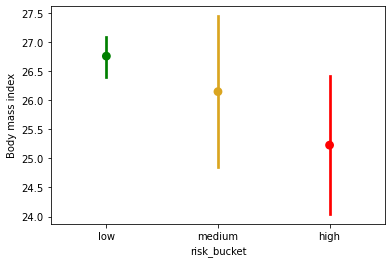

In [ ]:
# Does the BMI of the employee impact their risk for taking time off?
sns.pointplot(data=aaw, x='risk_bucket', y='Body mass index', palette=risk_colors);

While the `low` risk bucket employees are shorter, they also have a higher average BMI than the `high` risk bucket employees.  

In [ ]:
# Mapping the Reason for Absence values back to their actual reasons
reason_map = {
    1: 'infectious_disease',
    2: 'neoplasms',
    3: 'blood_disease',
    4: 'metabolic_disease',
    5: 'mental_health',
    6: 'nervous_system',
    7: 'eye_disease',
    8: 'ear_disease',
    9: 'circulatory',
    10: 'respiratory',
    11: 'digestive',
    12: 'skin_disease',
    13: 'musculoskeletal',
    14: 'urological',
    15: 'pregnancy_related',
    16: 'perinatal',
    17: 'genetic_diseases',
    18: 'abnormal_labs',
    19: 'injury',
    20: 'external_causes',
    21: 'health_services',
    22: 'patient_follow-up',
    23: 'medical_consultation',
    24: 'blood_donation',
    25: 'lab_exam',
    26: 'unjustified_absence',
    27: 'physiotherapy',
    28: 'dental_consult'
}
aaw['Reason for absence'] = aaw['Reason for absence'].map(reason_map)

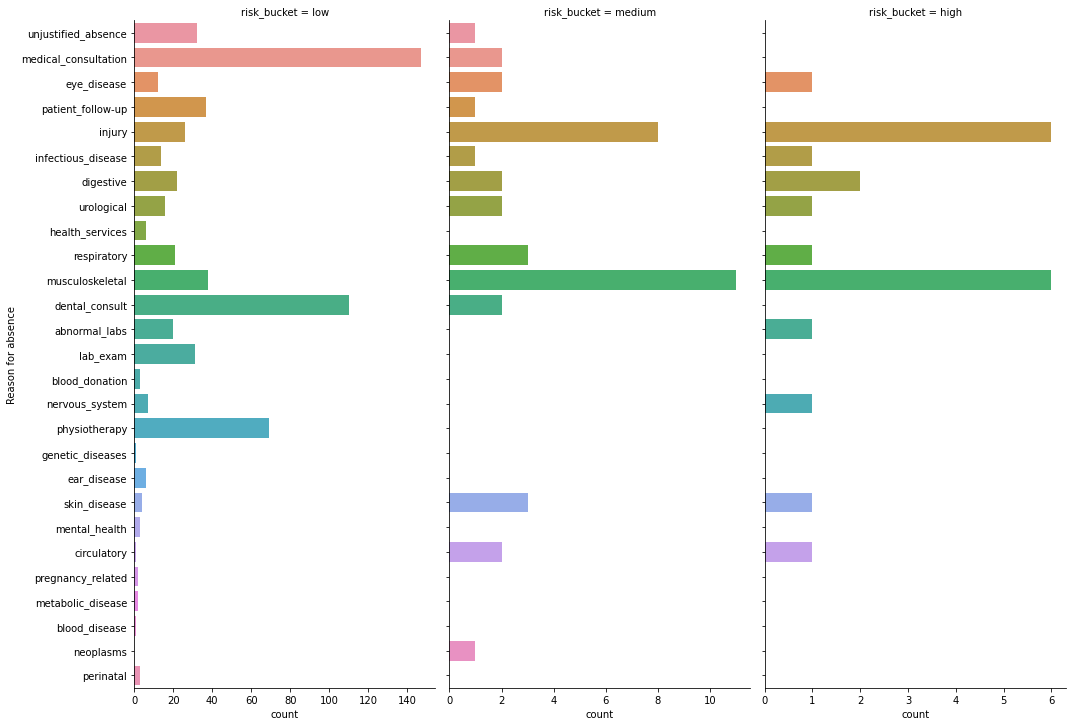

In [ ]:
# Do the different risk buckets have different reasons for their absences?
sns.catplot(data=aaw, col='risk_bucket', y='Reason for absence', kind='count', sharex=False, height=10, aspect=0.5, orient='v');

The `low` risk bucket employees are more likely to miss work due to routine checkups, like a medical or dental consultation or a physiotherapy appointment.  The `medium` and `high` risk bucket employees are more likely to miss work due to injury of some kind. 

## **Tuesday**

After doing a bunch of EDA on the different features and how they were related to the different risk buckets, we learned some patterns and trends in the data.  Now, we need to check to see how the different features relate to one another so we don't double count a feature and risk overfitting — that phenomenon is also referred to as [multicollinearity](https://www.statisticshowto.com/multicollinearity/).

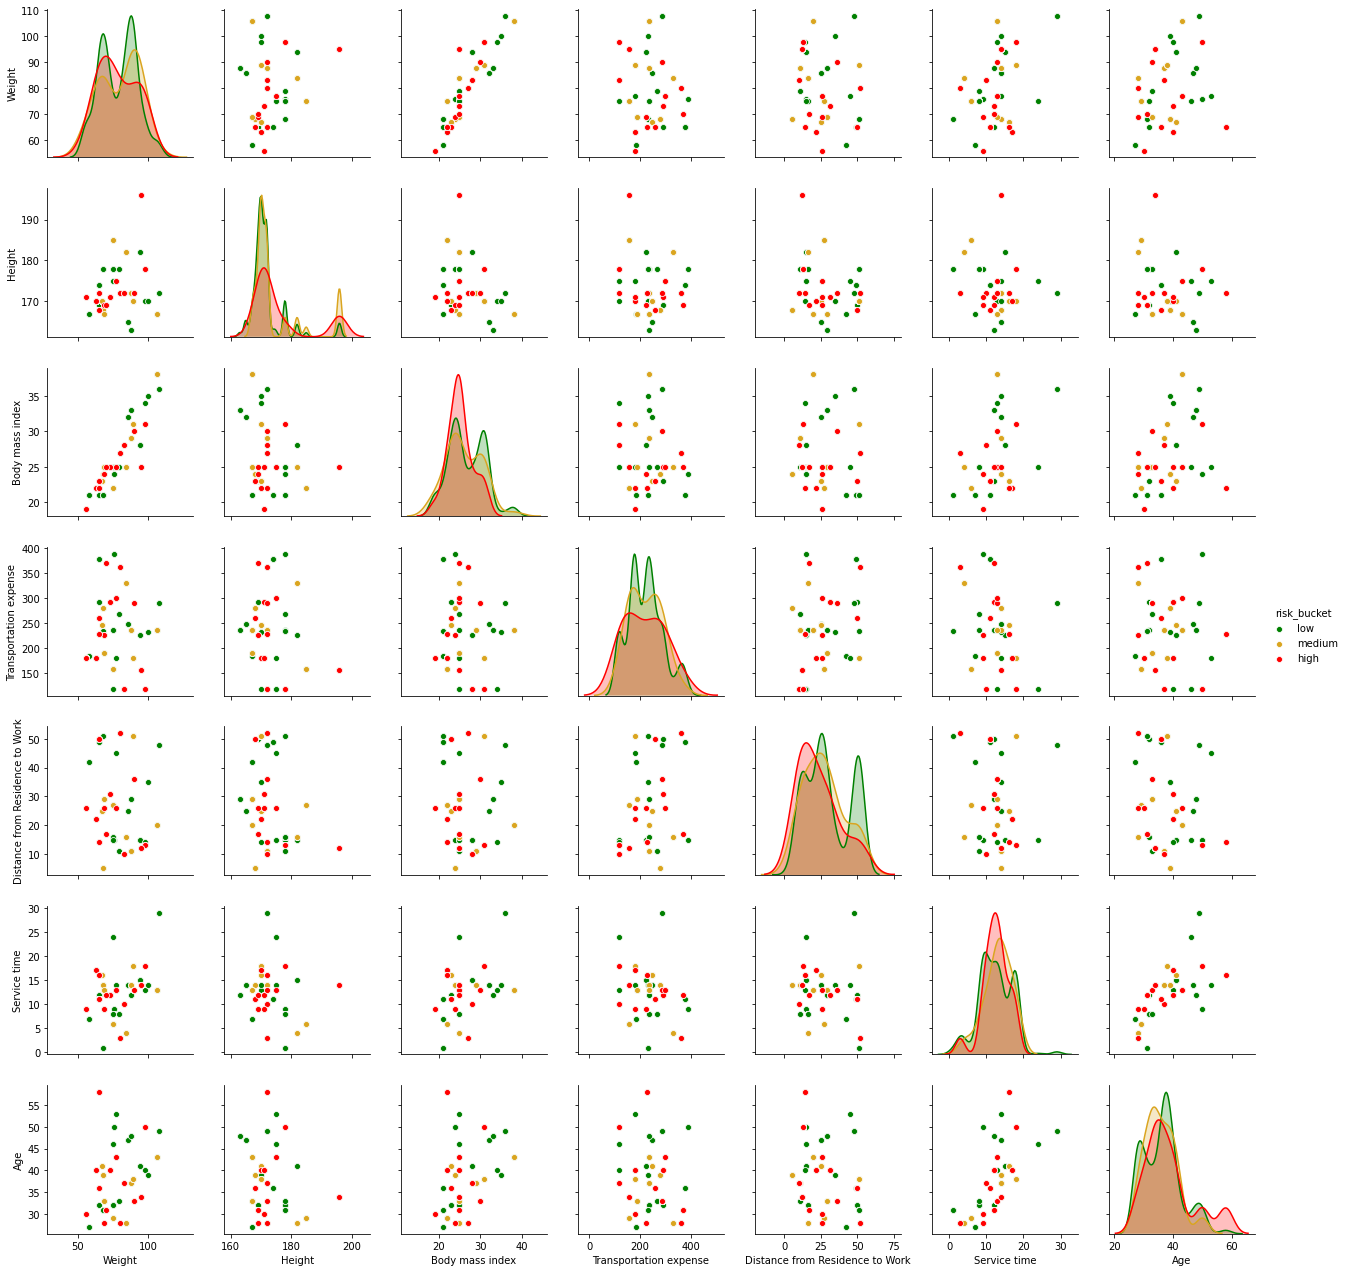

In [ ]:
# How do the distributions of different features relate to other features?
sns.pairplot(aaw[['Weight', 'Height', 'Body mass index','risk_bucket',
                  'Transportation expense', 'Distance from Residence to Work',
       'Service time', 'Age',]], hue='risk_bucket', palette=risk_colors);

Features that appear to be highly correlated are:
- Weight and Body mass index
- Age and service time

Let's check the correlation of all features with a heatmap.

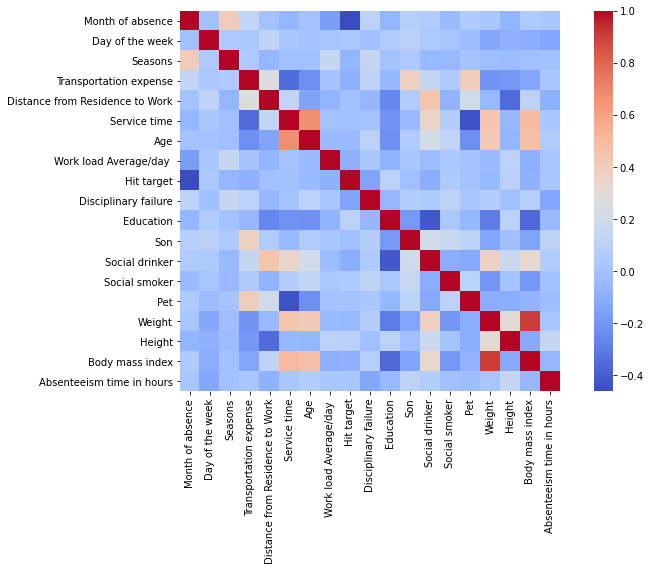

In [ ]:
# How are all features correlated to one another?
f, ax = plt.subplots(figsize=(12, 7))
ax = sns.heatmap(aaw.corr(), square=True, cmap='coolwarm');

As confirmed by the heatmap, there is a high correlation between:
- Age and Service time
- Body mass index and Weight

We'll want to determine which one from each pair to keep for modelling. 

#### Feature Selection

Using the information from our EDA, we know that we'll need to eliminate the multicollinearity, so let's take a closer look at each pair to determine what our next steps should be.

**Service Time and Age**

In [ ]:
# Is Service time or Age more highly correlated with Absenteeism time in hours?
aaw[['Absenteeism time in hours', 'Service time', 'Age']].corr()

,Absenteeism time in hours,Service time,Age
Absenteeism time in hours,1.000000,0.019029,0.065760
Service time,0.019029,1.000000,0.670979
Age,0.065760,0.670979,1.000000


  - Analysis: Age is more highly correlated to Absenteeism time
  - Decision: Drop `Service time` feature from dataset


  **Body Mass Index and Weight**

In [ ]:
# Is BMI, Height, or Weight more highly correlated with Absenteeism time in hours?
aaw[['Absenteeism time in hours', 'Body mass index', 'Height', 'Weight']].corr()

,Absenteeism time in hours,Body mass index,Height,Weight
Absenteeism time in hours,1.000000,-0.049719,0.144420,0.015789
Body mass index,-0.049719,1.000000,-0.121049,0.904117
Height,0.144420,-0.121049,1.000000,0.306802
Weight,0.015789,0.904117,0.306802,1.000000


- Analysis: BMI takes into account height and weight, but it looks like height and weight are differently correlated to absenteeism time, so it makes more sense to keep the actual Height and Weight over BMI.

- Decision: Drop `Body mass index` feature from dataset

In [ ]:
# Dropping BMI and Service time from data
aaw.drop(labels=['Service time', 'Body mass index'], axis=1, inplace=True)

In [ ]:
# Checking both columns were dropped
aaw.head()

,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Absenteeism time in hours,risk_bucket,edu_mapped
ID,,,,,,,,,,,,,,,,,,,,
11,unjustified_absence,7,3,1,289,36,33,239.554,97,0,1,2,1,0,1,90,172,4,low,high school
36,NaN,7,3,1,118,13,50,239.554,97,1,1,1,1,0,0,98,178,0,low,high school
3,medical_consultation,7,4,1,179,51,38,239.554,97,0,1,0,1,0,0,89,170,2,low,high school
7,eye_disease,7,5,1,279,5,39,239.554,97,0,1,2,1,1,0,68,168,4,low,high school
11,medical_consultation,7,5,1,289,36,33,239.554,97,0,1,2,1,0,1,90,172,2,low,high school


### Initial Findings

Now that we've completed our deep dive on EDA, it's time to prepare our initial findings to update the Stakeholders on what we've learned that will support our answer to the big question: _What is the risk factor in insuring a person?_


```
We used an employee's absenteeism time bucketed into risk groups as a proxy for risk of insuring.  From those buckets, we learned:
- Most people are a low insurance risk
- High risk employees:
  - live closer to work, 
  - are less educated, 
  - are social drinkers and smokers, 
  - have more children, 
  - are taller, 
  - and are more prone to injury
- A higher expected work load per day contributes to a higher insurance risk
- Factors that do not impact insurance risk: transportation expenses, age, service time, how frequently they hit their targets, or if they have pets
```




## **Wednesday**

After sharing our initial findings with stakeholders, we're ready to get our data ready for modeling and run some baseline models to determine the best model for this application.

In [ ]:
# First encode our data that is non-numerical
# we don't want to encode the risk bucket because we want it to be categories
encoded = pd.get_dummies(aaw.drop(['risk_bucket'], axis=1))

In [ ]:
# Check out what our data looks like after encoding
encoded.head()

,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Absenteeism time in hours,Reason for absence_abnormal_labs,Reason for absence_blood_disease,Reason for absence_blood_donation,Reason for absence_circulatory,Reason for absence_dental_consult,Reason for absence_digestive,Reason for absence_ear_disease,Reason for absence_eye_disease,Reason for absence_genetic_diseases,Reason for absence_health_services,Reason for absence_infectious_disease,Reason for absence_injury,Reason for absence_lab_exam,Reason for absence_medical_consultation,Reason for absence_mental_health,Reason for absence_metabolic_disease,Reason for absence_musculoskeletal,Reason for absence_neoplasms,Reason for absence_nervous_system,Reason for absence_patient_follow-up,Reason for absence_perinatal,Reason for absence_physiotherapy,Reason for absence_pregnancy_related,Reason for absence_respiratory,Reason for absence_skin_disease,Reason for absence_unjustified_absence,Reason for absence_urological,edu_mapped_graduate,edu_mapped_high school,edu_mapped_master/doctor,edu_mapped_post graduate
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11,7,3,1,289,36,33,239.554,97,0,1,2,1,0,1,90,172,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
36,7,3,1,118,13,50,239.554,97,1,1,1,1,0,0,98,178,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,7,4,1,179,51,38,239.554,97,0,1,0,1,0,0,89,170,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
7,7,5,1,279,5,39,239.554,97,0,1,2,1,1,0,68,168,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
11,7,5,1,289,36,33,239.554,97,0,1,2,1,0,1,90,172,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
# Identifying our inputs and target from our data
# We remove the Absenteeism time because that's how we bucketed people in the first place
X = encoded.drop(['Absenteeism time in hours'], axis=1)
y = aaw['risk_bucket']

# Splitting data into train and test groups for training the model and assessing it
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, )

#### Choosing baseline models

- We're trying to predict which of the 3 risk buckets a person will fall into, so these need to be **classification** models.
- Since this is a small, unbalanced data set, I'll stick with tree-based models, as they can handle these unbalanced classes without creating too much bias

##### Model 1: Decision Tree Classifier

In [ ]:
# Import model
from sklearn.tree import DecisionTreeClassifier

# Instantiate (start up) model
dt = DecisionTreeClassifier(random_state=42)
# Fit model on the training data
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [ ]:
# Score the model on it's accuracy using cross validation
dt_score = cross_val_score(dt, X_test, y_test, cv=3)
print(f'Decision Tree score: {dt_score.mean(): .3f} +/- {2*dt_score.std(): .4f}')

Decision Tree score:  0.852 +/-  0.0670


This _looks_ pretty good, but we have to remember that this is an unbalanced data set, so it'll actually be better if we look at the [confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) to see what classes we've correctly predicted.

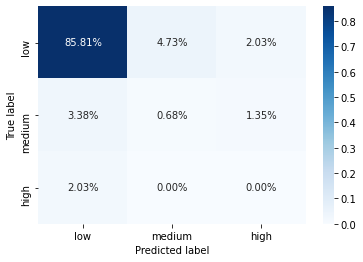

In [ ]:
# Predicting the classes from the test set
y_pred_dt = dt.predict(X_test)

# Creating a confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt, labels=labels)
# Visualizing the confusion matrix as a heatmap
sns.heatmap(cm_dt/np.sum(cm_dt), annot=True, cmap='Blues', 
            fmt='.2%', xticklabels=labels, yticklabels=labels)
plt.ylabel('True label')
plt.xlabel('Predicted label');

As expected, our model is really good at predicting the dominant bucket (`low` risk), but didn't do a good job of predicting either of the other buckets.

##### Model 2: Random Forest Classifier

In [ ]:
# Import model
from sklearn.ensemble import RandomForestClassifier

# Instantiate (start up) model
rf = RandomForestClassifier(random_state=42)
# Fit model on the training data
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
# Score the model on it's accuracy using cross validation
rf_score = cross_val_score(rf, X_test, y_test, cv=3)
print(f'Random Forest score: {rf_score.mean(): .5f} +/- {2*rf_score.std(): .6f}')

Random Forest score:  0.91905 +/-  0.031675


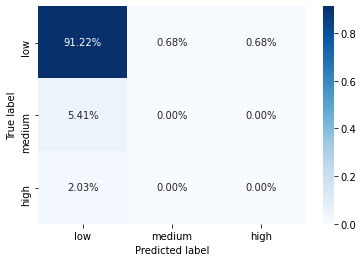

In [ ]:
# Predicting the classes from the test set
y_pred_rf = rf.predict(X_test)

# Creating a confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=labels)
# Visualizing the confusion matrix as a heatmap
sns.heatmap(cm_rf/np.sum(cm_rf), annot=True, cmap='Blues',
            fmt='.2%', xticklabels=labels, yticklabels=labels)
plt.ylabel('True label')
plt.xlabel('Predicted label');

The Random Forest model is slightly better at correctly predicting the `low` risk bucket, but the majority of the other incorrect predictions were also in the `low` bucket, suggesting this model might only really be good at predicting `low` risk people.

##### Model 3: Gradient Boosting Classifier

In [ ]:
# Import model
from sklearn.ensemble import GradientBoostingClassifier

# Instantiate (start up) model
gb = GradientBoostingClassifier(random_state=42)
# Fit model on the training data
gb.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
# Score the model on it's accuracy using cross validation
gb_score = cross_val_score(gb, X_test, y_test, cv=3)
print(f'Gradient boosting score: {gb_score.mean(): .3f} +/- {2*gb_score.std(): .4f}')

Gradient boosting score:  0.872 +/-  0.0673


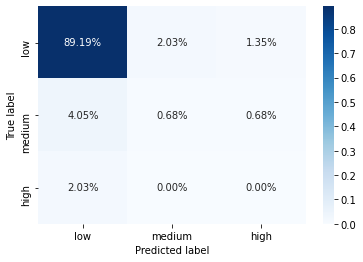

In [ ]:
# Predicting the classes from the test set
y_pred_gb = gb.predict(X_test)

# Creating a confusion matrix
cm_gb = confusion_matrix(y_test, y_pred_gb, labels=labels)
# Visualizing the confusion matrix as a heatmap
sns.heatmap(cm_gb/np.sum(cm_gb), annot=True, cmap='Blues',
            fmt='.2%', xticklabels=labels, yticklabels=labels)
plt.ylabel('True label')
plt.xlabel('Predicted label');

Again, this is similar to the Random Forest model, where most of the predictions are for `low` risk, no matter what the true label is.

##### Model 4: Support Vector Machine Classifier

In [ ]:
# Import model
from sklearn.svm import SVC

# Instantiate (start up) model
svc = SVC(random_state=42)
# Fit model on the training data
svc.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
# Score the model on it's accuracy using cross validation
svc_score = cross_val_score(svc, X_test, y_test, cv=3)
print(f'Gradient boosting score: {svc_score.mean(): .3f} +/- {2*svc_score.std(): .4f}')

Gradient boosting score:  0.926 +/-  0.0185


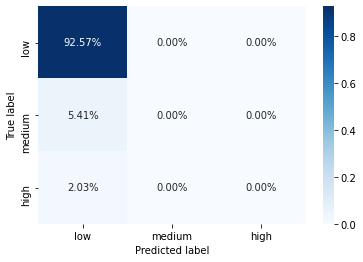

In [ ]:
# Predicting the classes from the test set
y_pred_svc = svc.predict(X_test)

# Creating a confusion matrix
cm_svc = confusion_matrix(y_test, y_pred_svc, labels=labels)
# Visualizing the confusion matrix as a heatmap
sns.heatmap(cm_svc/np.sum(cm_svc), annot=True, cmap='Blues',
            fmt='.2%', xticklabels=labels, yticklabels=labels)
plt.ylabel('True label')
plt.xlabel('Predicted label');

This model is even worse because it predicted that 100% of the people would be in the `low` risk bucket.  

While not great, the most accurate model without predicting too many `low` risk people is the Random Forest Classifier - let's try it with some engineered features, but first, let's take a look at the features that were important to the model's predictions.

In [ ]:
# Creating a DataFrame with feature importances
impt = pd.DataFrame(zip(X_test.columns, rf.feature_importances_), columns=['Column name', 'Feature Importance'])
impt.sort_values(by='Feature Importance', ascending=False)

,Column name,Feature Importance
1,Day of the week,0.117550
6,Work load Average/day,0.105659
0,Month of absence,0.081114
7,Hit target,0.080744
27,Reason for absence_injury,0.064324
2,Seasons,0.051764
32,Reason for absence_musculoskeletal,0.050411
15,Height,0.044697
3,Transportation expense,0.041479
4,Distance from Residence to Work,0.038708


The work load of the person has the most influence on the model's decision, followed by information about the day and month of absence, whether they hit their target or not, and the injury-related reasons for absence.

## **Thursday**
### Feature Engineering
Now that we've seen the performance of our baseline models, let's do some feature engineering to see if we can garner more information out of the existing features to improve our model.

**Dependents**

From my experience, the more dependents (pets/children) a person has, the more time they have to take off of work to care for these dependents.  Maybe a feature that combines the two would create a better overall picture of what responsibilities a person has outside of work.

In [ ]:
# Creating dependents feature by adding Son and Pet
aaw['dependents'] = aaw['Son'] + aaw['Pet']

In [ ]:
# Taking a look at how that worked
aaw[['dependents', 'Son', 'Pet']].head()

,dependents,Son,Pet
ID,,,
11,3,2,1
36,1,1,0
3,0,0,0
7,2,2,0
11,3,2,1


In [ ]:
# Checking the spread of this new field
aaw['dependents'].describe()

count    740.000000
mean       1.764865
std        1.805527
min        0.000000
25%        0.000000
50%        2.000000
75%        3.000000
max        9.000000
Name: dependents, dtype: float64

**Transportation Expense per Km**

Since we have both transportation expense and distance to work, maybe the expense per km might be helpful in predicting risk bucket.

In [ ]:
# Calculating expense per km
aaw['transportation_expense_per_km'] = aaw['Transportation expense'] / aaw['Distance from Residence to Work']

In [ ]:
# Taking a look at our work
aaw[['Transportation expense', 'Distance from Residence to Work', 'transportation_expense_per_km']].head()

,Transportation expense,Distance from Residence to Work,transportation_expense_per_km
ID,,,
11,289,36,8.027778
36,118,13,9.076923
3,179,51,3.509804
7,279,5,55.800000
11,289,36,8.027778


In [ ]:
# Checking out the distribution of transportation expenses
aaw['transportation_expense_per_km'].describe()

count    740.000000
mean       9.549425
std        6.317286
min        3.509804
25%        6.393139
50%        8.653846
75%       11.750000
max       55.800000
Name: transportation_expense_per_km, dtype: float64

**Social Risk**

Since we have both social smoking and social drinking, they might have even more impact on risk bucket if they either do neither or both.

In [ ]:
# Give social drinking 1/2 point, and social smoking 2 points (riskier) - sum the two
aaw['social_risk'] = aaw['Social drinker']/2 + aaw['Social smoker']*2

In [ ]:
# Take a look at our work
aaw[['social_risk', 'Social drinker', 'Social smoker']].head()

,social_risk,Social drinker,Social smoker
ID,,,
11,0.5,1,0
36,0.5,1,0
3,0.5,1,0
7,2.5,1,1
11,0.5,1,0


In [ ]:
# Distributions of the three features
aaw[['social_risk', 'Social drinker', 'Social smoker']].describe()

,social_risk,Social drinker,Social smoker
count,740.000000,740.000000,740.000000
mean,0.429730,0.567568,0.072973
std,0.550981,0.495749,0.260268
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.500000,1.000000,0.000000
75%,0.500000,1.000000,0.000000
max,2.500000,1.000000,1.000000


**Reason for absence due to chronic disease**

There are a bunch of different reasons for why someone might miss work, so maybe we can bucket these into chronic vs acute reasons, the thinking that excuses related to chronic diseases might relate to a higher risk individual

In [ ]:
# Identifying all reasons related to possible chronic diseases
reason_chronic = ['eye_disease', 'infectious_disease', 'digestive', 'urological', 
                  'repspiratory', 'abnormal_labs', 'nervous_system', 'genetic_diseases',
                  'ear_disease', 'skin_disease', 'circulatory', 'metabolic_disease', 
                  'blood_disease', 'neoplasm']

# Use list comprehension to identify excuses related to chronic diseases
aaw['reason_chronic'] = [1 if x in reason_chronic else 0 for x in aaw['Reason for absence']]

In [ ]:
# Checking out our work
aaw[['Reason for absence', 'reason_chronic']].head()

,Reason for absence,reason_chronic
ID,,
11,unjustified_absence,0
36,NaN,0
3,medical_consultation,0
7,eye_disease,1
11,medical_consultation,0


Now that we've engineered some features, we need to re-encode our data to get our data ready for modeling again

In [ ]:
# Encoding everything except for risk bucket (again) 
# and reason (we engineered a feature to take its place)
encoded_fe = pd.get_dummies(aaw.drop(['risk_bucket', 
                                   'Reason for absence'
                                   ], axis=1))

Let's take a look at how our new features are correlated to absenteeism time in hours to determine if these are improvements to the original features.

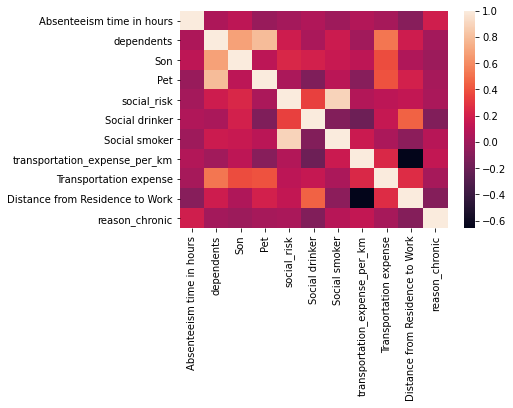

In [ ]:
# Plotting heatmap of our original and engineered features
sns.heatmap(encoded_fe[['Absenteeism time in hours', 
                 'dependents', 'Son', 'Pet',
                 'social_risk', 'Social drinker', 'Social smoker', 
                 'transportation_expense_per_km', 'Transportation expense', 'Distance from Residence to Work',
                 'reason_chronic', ]].corr());

Results:
- Son is actually more highly correlated to absenteeism than dependent
  - Decision: Keep Son and Pet
- Social Risk is similar to Social drinker 
  - Decision: Try with Social Risk (might want to model with each combination and determine how impacts model)
- Transportation expense per km is more highly correlated to absenteeism than the other two
  - Decision: Keep expense per km
- Reason chronic looks well correlated to absenteeism time in hours
  - Decision: Keep Reason Chronic

> *You be the Data Scientist*: The features that we engineered are one of the most important subjective choices that a data scientist makes in their daily workflow. Can you think of combining our features in any other ways to create new ones? What would the value be?

## **Friday**

### Refined Model
Time to test our engineered features and see how they impact the model predictions!

In [ ]:
# Identifying which columns to use as inputs
X_fe = encoded_fe.drop(['dependents', 'Social drinker', 'Social smoker',
                        'Transportation expense', 'Distance from Residence to Work',
                        'Absenteeism time in hours',
                        # Also removing columns that wouldn't be known at time of insurance
                        'Month of absence', 'Day of the week', 'Seasons'
                        ], axis=1)
# Keep the risk bucket target variable
y = aaw['risk_bucket']

# Train/test split of data
X_train_fe, X_test_fe, y_train, y_test = train_test_split(X_fe, y, test_size=0.2, random_state=42)

In [ ]:
# Instantiating a new Random Forest Classifier
rf_fe = RandomForestClassifier(random_state=42)
# Fit using training data
rf_fe.fit(X_train_fe, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
# Assess model using cross validation
rf_score_fe = cross_val_score(rf_fe, X_test_fe, y_test, cv=3)
print(f'Feature Engineered score: {rf_score_fe.mean(): .5f} +/- {2*rf_score_fe.std(): .6f}')

Feature Engineered score:  0.89184 +/-  0.020272


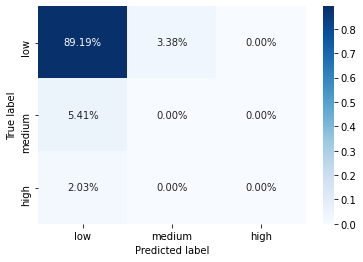

In [ ]:
# Predicting classes from test set
y_pred_fe = rf_fe.predict(X_test_fe)
# Create confusion matrix
cm_fe = confusion_matrix(y_test, y_pred_fe, labels=labels)
# Plot confusion matrix
sns.heatmap(cm_fe/np.sum(cm_fe), annot=True, cmap='Blues',
            fmt='.2%', xticklabels=labels, yticklabels=labels)
plt.ylabel('True label')
plt.xlabel('Predicted label');

Well, this isn't that much better.  We might need to re-assess some aspects about this project.

First, let's check to see what features were important in the model's decisions.

In [ ]:
# Check which features were important in the model
impt_fe = pd.DataFrame(zip(X_test_fe.columns, rf_fe.feature_importances_), columns=['Column name', 'Feature Importance'])
impt_fe.sort_values(by='Feature Importance', ascending=False)

,Column name,Feature Importance
1,Work load Average/day,0.350167
2,Hit target,0.219976
11,reason_chronic,0.091368
7,Weight,0.064486
8,Height,0.061409
0,Age,0.056089
9,transportation_expense_per_km,0.056070
5,Son,0.034789
6,Pet,0.019180
10,social_risk,0.018500


Seems like work load is a good indicator of a person's risk bucket, as is the proportion of time they hit their targets.  And our engineered feature of chronic reason for absence is also a good predictor of risk.

We're nearing the end of our week and it's time to summarize our findings and next steps.

### Findings and Recommendations:
- Need more data - 740 people isn't enough to create a strong model, especially with unbalanced classes
- Try building model to predict actual Absenteeism time instead of risk buckets
- Do more investigation into engineered features and how they are related to risk buckets and how they impact the models

- Summary of findings: 
  - A higher expected work load per day contributes to a higher insurance risk
  - Most people are a `low` insurance risk
  - `High` risk employees:
    - have chronic illnesses,
    - live closer to work, 
    - are less educated, 
    - are social drinkers and smokers, 
    - have more children, 
    - are taller, 
    - and are more prone to injury


> *You be the Data Scientist*: These are some of the initial findings from our "week of work", but what other trends or patterns do you think are important to report? Why should they be included?